In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import scanpy.api as sc
import matplotlib.pyplot as plt
import seaborn
import itertools as it

/home/anders/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
cnts = sc.read_h5ad( "Tabula_muris_10x.h5ad" )
cnts

AnnData object with n_obs × n_vars = 54837 × 23433 
    obs: 'tissue', 'channel', 'cell_ontology_class', 'cell_ontology_id', 'cell', 'mouse.id', 'subtissue', 'mouse.sex'

In [4]:
cntsT = cnts.transpose()

In [5]:
endo_gold = cnts.obs_names[ ( cntsT["Pecam1",:].X > 3 ) & ( cntsT["Cdh5",:].X > 3 ) ]
endo_gold

Index(['10X_P4_3_CCGTTCAGTTCCCTTG', '10X_P4_4_ACTGAGTGTTGCGTTA',
       '10X_P4_4_ATCTACTAGGCAATTA', '10X_P4_4_CATGACAAGGACTGGT',
       '10X_P4_4_CCTAAAGAGCTCCTTC', '10X_P4_4_CGATCGGAGTGGAGTC',
       '10X_P4_4_GAATGAAAGCTTATCG', '10X_P4_4_GCACTCTCAGCGATCC',
       '10X_P4_4_GCTTCCAAGTCCTCCT', '10X_P4_4_GTCCTCATCATGTGGT',
       ...
       '10X_P8_15_GCTGCAGCAGGGAGAG', '10X_P8_15_GGGAGATCACTTCTGC',
       '10X_P8_15_GGTGTTAAGATCCCGC', '10X_P8_15_GTAACGTGTAATAGCA',
       '10X_P8_15_TAGAGCTAGTTTAGGA', '10X_P8_15_TCAACGACATTCCTGC',
       '10X_P8_15_TCGTAGAAGCTTATCG', '10X_P8_15_TTGCCGTGTCAACTGT',
       '10X_P8_15_TTGTAGGCATCAGTCA', '10X_P8_15_TTTGTCAGTTGTCGCG'],
      dtype='object', name='index', length=915)

In [6]:
exprs = cnts.copy()
exprs.X = sp.sparse.vstack( np.sqrt( cnts.X[i,:] ) / np.sqrt( cnts.X[i,:].sum() ) for i in range(cnts.n_obs) )

In [104]:
a = exprs[ endo_gold, : ].X
endo_gold_dists = a.dot( a.transpose() ).todense() 
assert endo_gold_dists.max() < 1.001
endo_gold_dists[ endo_gold_dists > 1 ] = 1
endo_gold_dists = np.arccos( endo_gold_dists ) / ( np.pi / 2)

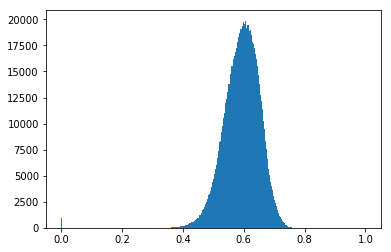

In [105]:
plt.hist( endo_gold_dists.flat, 300, range=(0,1) );

In [106]:
a = exprs[ np.random.choice( exprs.obs_names, endo_gold.shape[0] ), : ].X
dists_sample = a.dot( a.transpose() ).todense() 
assert dists_sample.max() < 1.001
dists_sample[ dists_sample > 1 ] = 1
dists_sample = np.arccos( dists_sample ) / ( np.pi/2 )

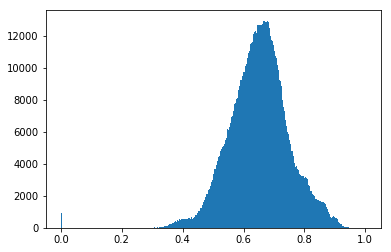

In [107]:
plt.hist( dists_sample.flat, 300, range=(0,1) );

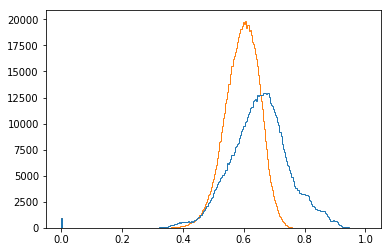

In [126]:
plt.hist( [ np.asarray(dists_sample).flatten(), np.asarray(endo_gold_dists).flatten() ], 
         bins=300, range=(0,1), histtype="step" );

In [127]:
a = ( exprs.X * exprs.X[17864,:].transpose() ).todense()

In [123]:
( a < .45 ).sum()

4905